In [32]:
import numpy as np
from matplotlib import pyplot as plt
from utils_torch import *

def get_sphere():
    u = np.linspace(0, 2*np.pi,200)
    v = np.linspace(0, np.pi, 200)
    x = np.outer(np.cos(u), np.sin(v)) 
    y = np.outer(np.sin(u), np.sin(v))
    z = np.outer(np.ones(np.size(u)), np.cos(v))

    fig = plt.figure(figsize=(10,10))
    ax = plt.axes(projection='3d')
    ax.plot_surface(x, y, z, color='g',alpha=0.2,cmap=plt.cm.YlGnBu_r)

    return ax



In [33]:
import torch
torch.set_default_dtype(torch.float64)

# Initial values
R0 = get_orth(3)
w0 = torch.tensor([-0.1, 0.1, 0.3])

# Step size and number of steps
dt = 0.01
N = 50_000

# Moments of inertia and inverse
diag_I = torch.tensor([1, 0.8, 0.1])
I = torch.diag(diag_I)
I_inv = torch.diag(1 / diag_I)

# Define the time derivatives
def w_dot(w):
    return torch.matmul(I_inv, torch.matmul(hat(torch.matmul(I, w)), w))

def R_dot(w):
    return hat(w)



Time stepping with explicit euler for $\omega$ and Lie euler using the Rodrigues formula for the orientation $R$.

In [34]:
Rs = [R0]
Rs_e = [R0]
ws = [w0]

for n in range(N):
    R0 = Rs[-1]
    w0 = ws[-1]
    
    #Lie Euler
    R1 = R0@rodrigues(dt*R_dot(w0))
    #Explicit Euler
    w1 = w0 + dt*w_dot(w0)

    Rs.append(R1)
    ws.append(w1)

Rs = torch.stack(Rs)
ws = torch.stack(ws)



In [35]:
print(dist_trajectory(Rs))

tensor(214.0039)


Plotting row $i$, $r_i \in S^2$ of $R$ trough time.

# Applying ES & DI control for a rigid body

Setting initial values and the target orientation ```Rref``` as well as gains ```Kp,Kd``` for the control problem.

In [42]:
#Initial values
R0 = get_orth(3)
R00 = R0
w0 = torch.tensor([0.3,0.2,0.2])

#Step size and number of steps
dt = 0.01
N = 10_000


#Controller gains and desired orientation
Kp = torch.diag(torch.tensor([1.]*3))
Kd = Kp*2
Rref = torch.eye(3)

Kp.requires_grad = True

#Moments of intertia and inverse 
diag_I = torch.tensor([1,0.8,1])
I = torch.diag(diag_I)
I_inv = torch.diag(1/diag_I)

#Defining the energy shaping and damping injection controls
u_es = lambda R,Kp: -.5*hat_inv(Kp@Rref.T@R - R.T@Rref@Kp.T)
u_di = lambda w,Kd: -Kd@w

#Time derivatives with controls
w_dot_es_di = lambda w,R,Kd,Kp : I_inv@(hat(I@w)@w + u_es(R,Kp) + u_di(w,Kd) )
R_dot = lambda w : hat(w) 

#Rotational energy and injected control energy (for plotting)
hamiltonian_rot = lambda w : 0.5*w.T@I_inv@w
hamiltonian_ref = lambda R : .5*torch.trace(Kp@(np.eye(3) - Rref.T@R))


In [43]:
def run_control(R0,w0,Rref,diag_I,Kp,Kd,tol=1e-4):
    R00 = R0
    Rs = [R0]
    ws = [w0]
    dt = 0.005

    #Moments of intertia and inverse 
    I = torch.diag(diag_I)
    I_inv = torch.diag(1/diag_I)


    #Defining the energy shaping and damping injection controls
    u_es = lambda R: -.5*hat_inv(Kp@Rref.T@R - R.T@Rref@Kp.T)
    u_di = lambda w: -Kd@w



    #Time derivatives with controls
    w_dot_es_di = lambda w,R : I_inv@(hat(I@w)@w + u_es(R) + u_di(w) )
    R_dot = lambda w : hat(w) 

    dist_to_ref = dist_so3(R0,Rref)/dist_so3(R0,Rref)

    while dist_to_ref > tol:
        R0 = Rs[-1]
        w0 = ws[-1]

        dist_to_ref = dist_so3(R0,Rref)/dist_so3(R00,Rref)

        #Lie Euler
        Rs.append(R0@rodrigues(dt*R_dot(w0)))
        #Explicit Euler
        ws.append(w0 + dt*w_dot_es_di(w0,R0))

    Rs = torch.stack(Rs)
    ws = torch.stack(ws)

    return Rs


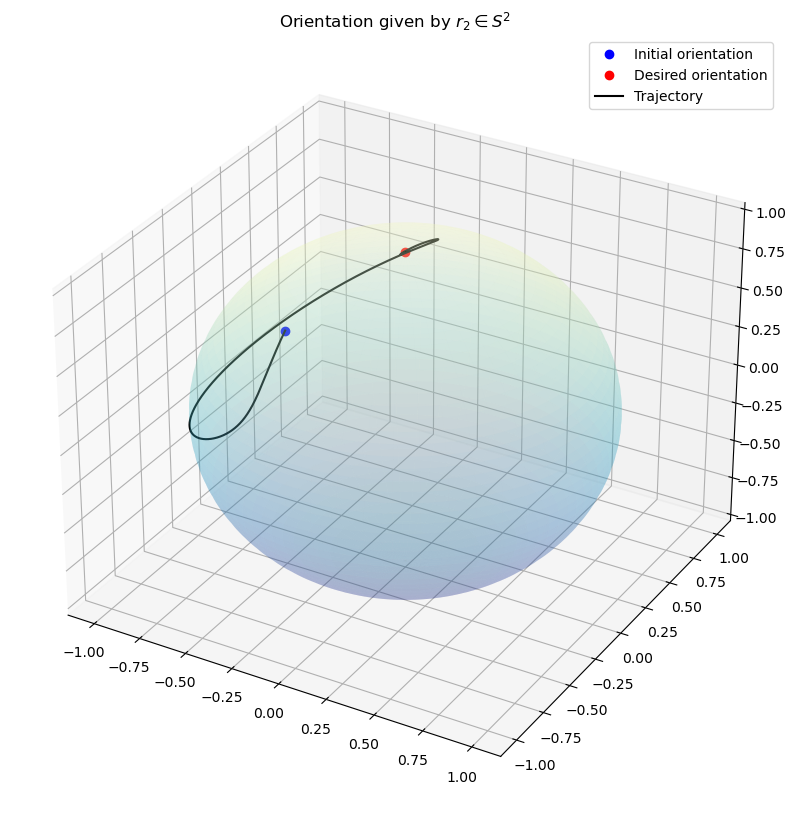

tensor(120.4919, grad_fn=<DivBackward0>)


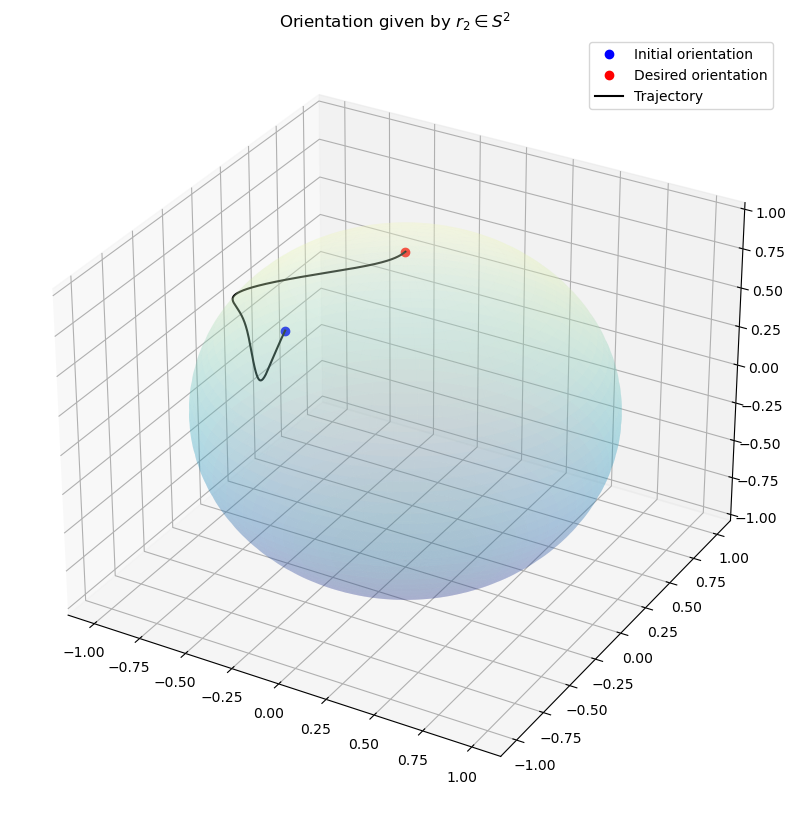

tensor(107.7829, grad_fn=<DivBackward0>)


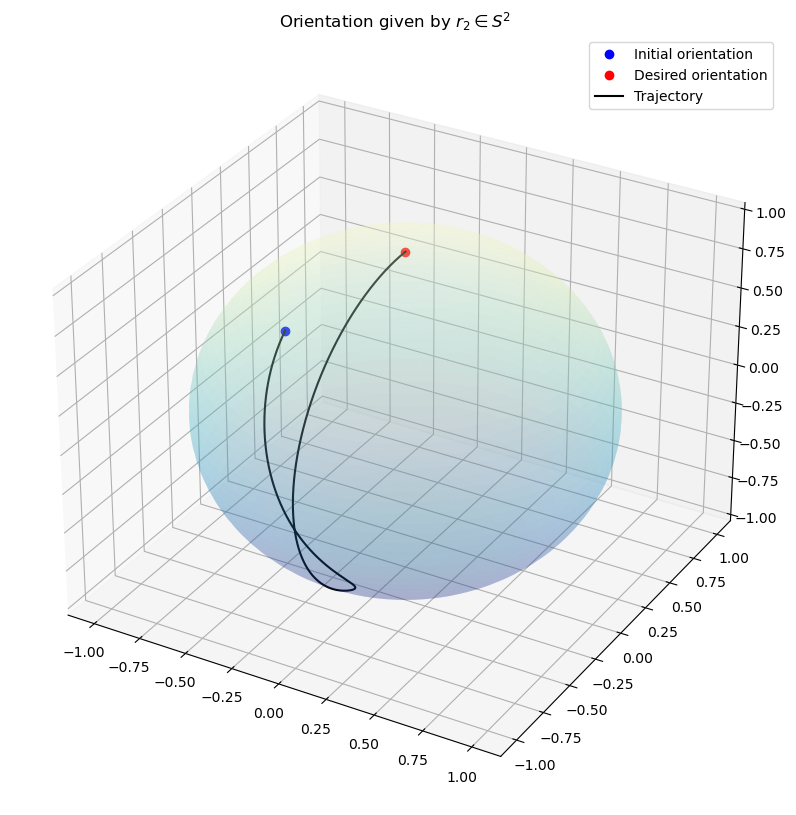

tensor(137.4456, grad_fn=<DivBackward0>)


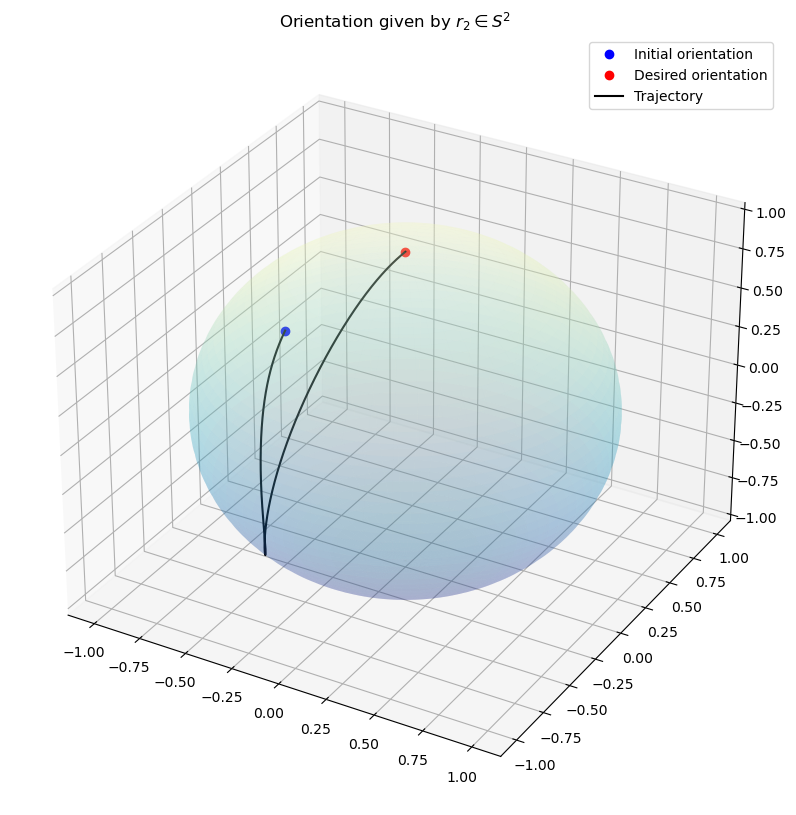

tensor(120.9821, grad_fn=<DivBackward0>)


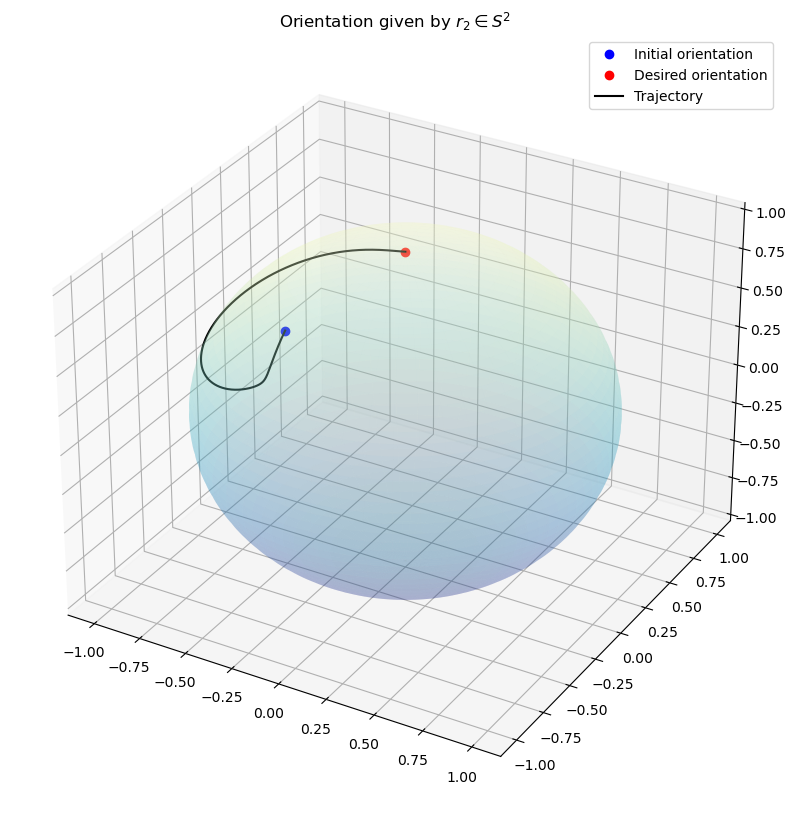

tensor(114.0830, grad_fn=<DivBackward0>)


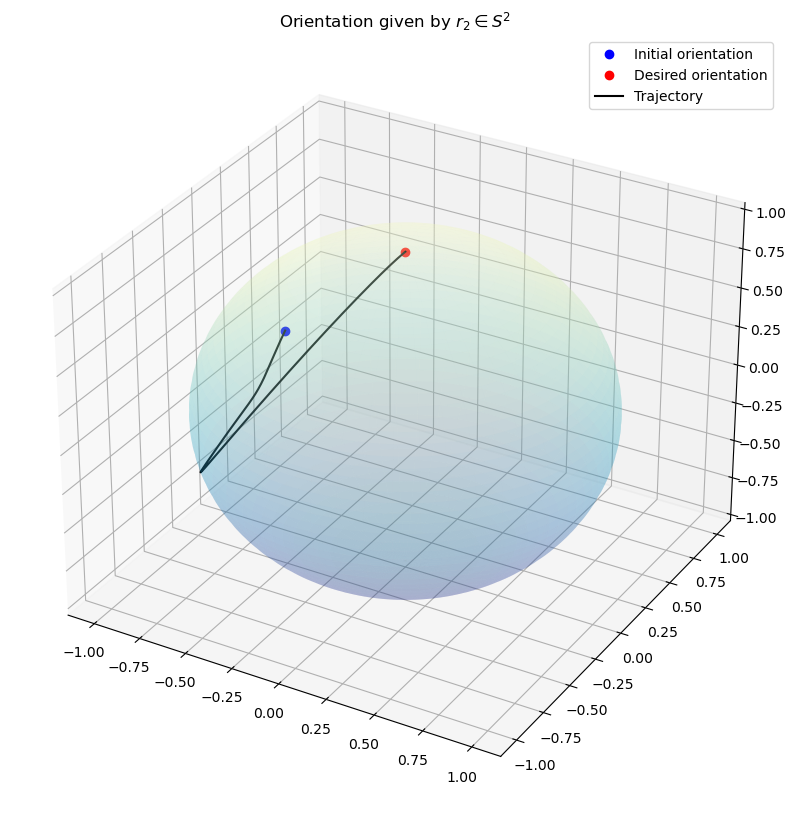

tensor(106.8070, grad_fn=<DivBackward0>)


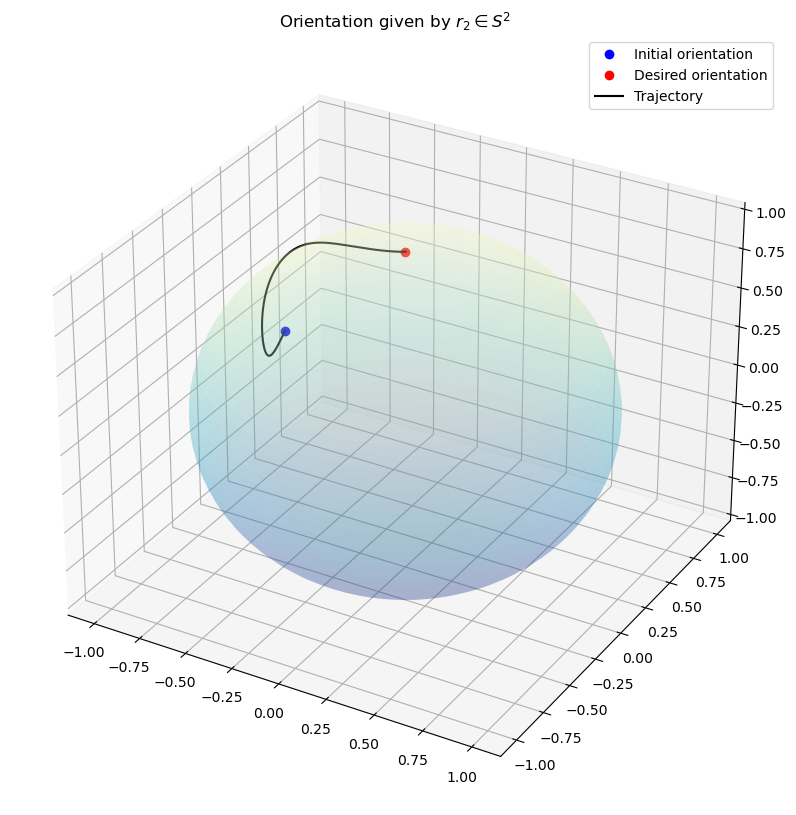

tensor(116.2956, grad_fn=<DivBackward0>)


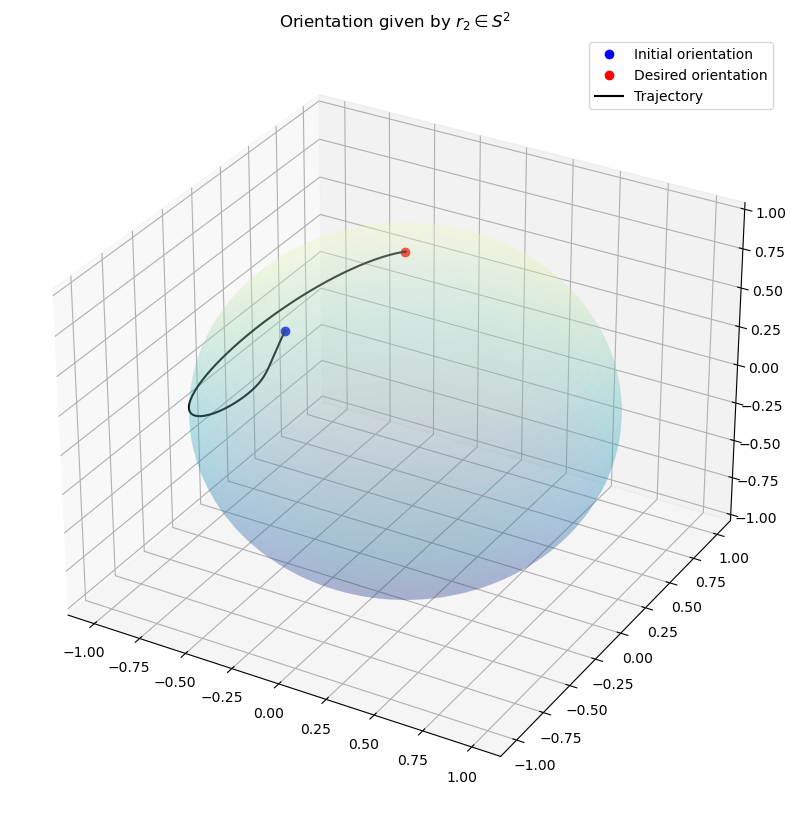

tensor(102.1559, grad_fn=<DivBackward0>)


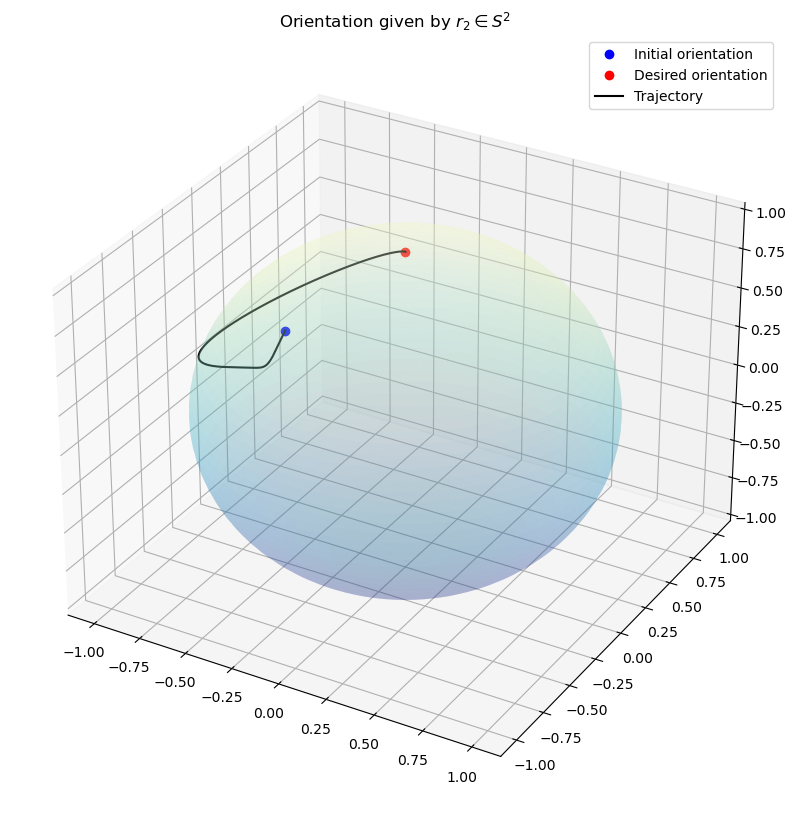

tensor(99.8794, grad_fn=<DivBackward0>)


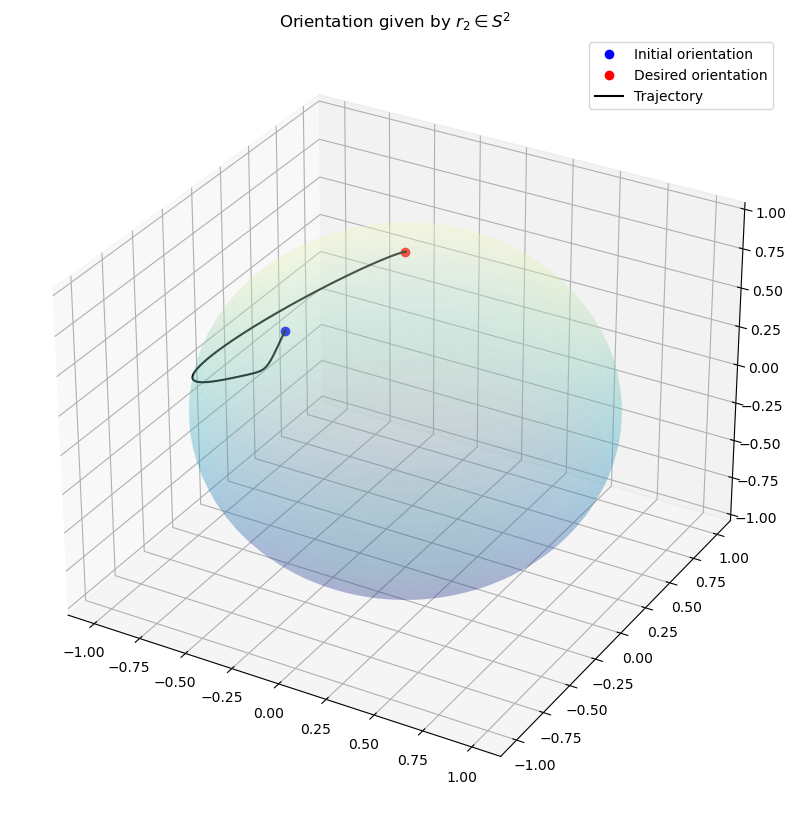

tensor(99.3818, grad_fn=<DivBackward0>)


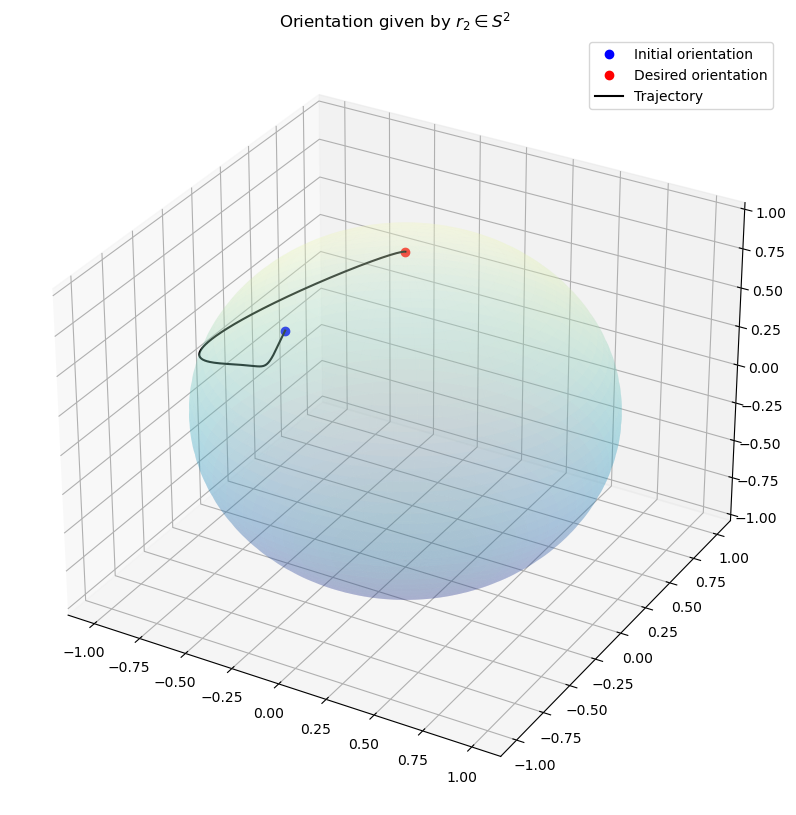

tensor(99.3364, grad_fn=<DivBackward0>)


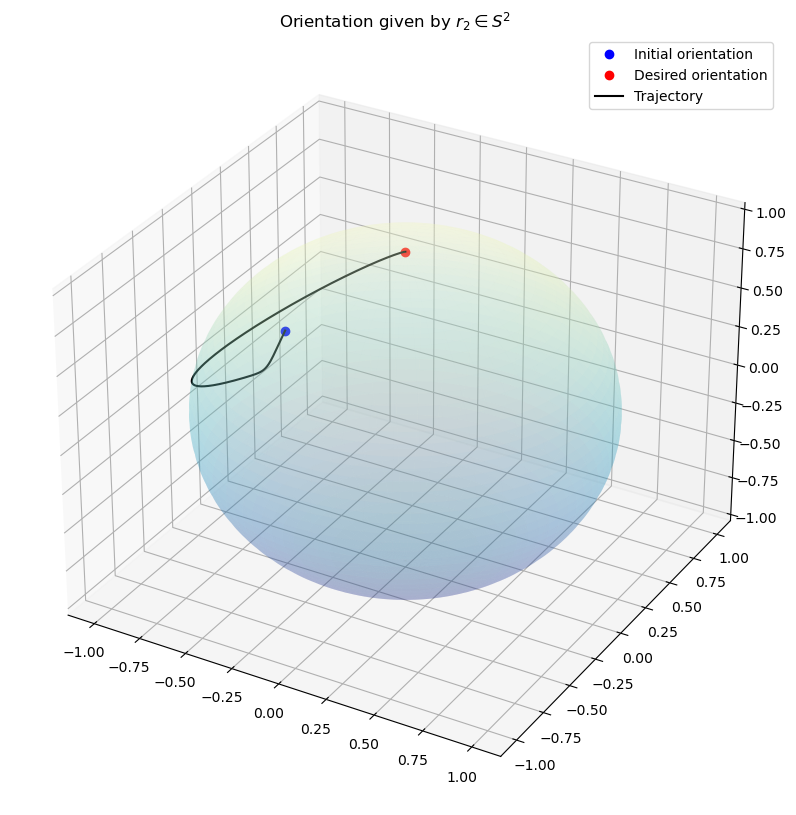

tensor(99.3382, grad_fn=<DivBackward0>)


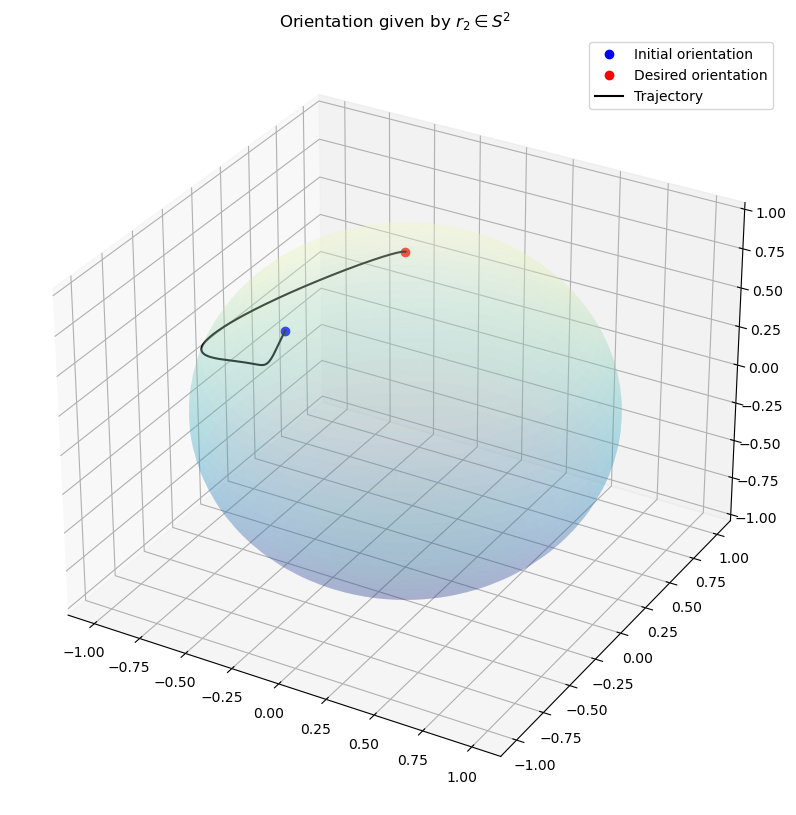

tensor(99.3932, grad_fn=<DivBackward0>)


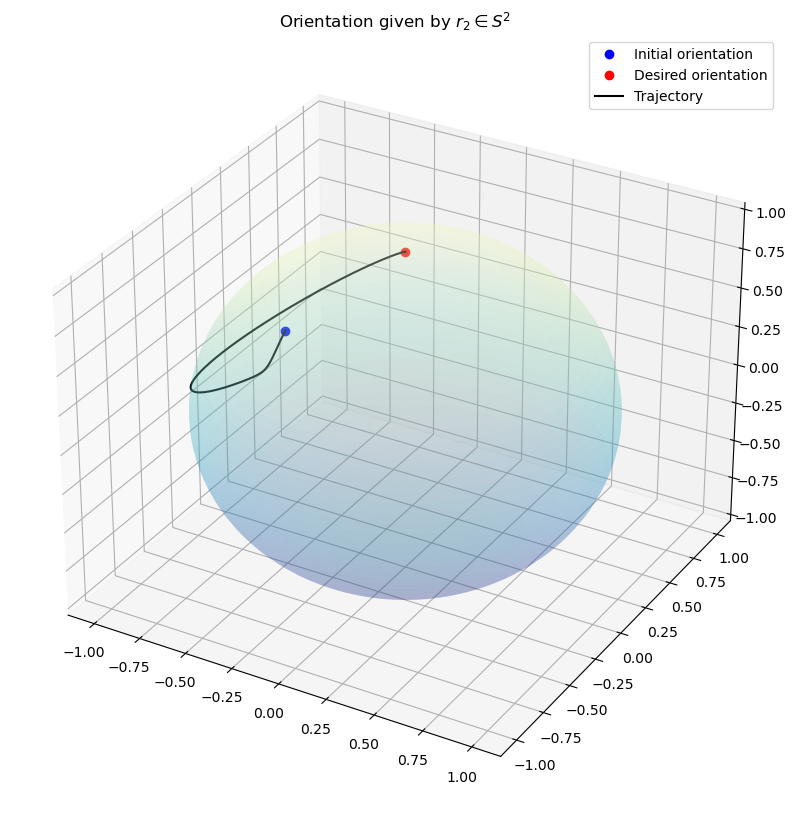

tensor(99.4706, grad_fn=<DivBackward0>)


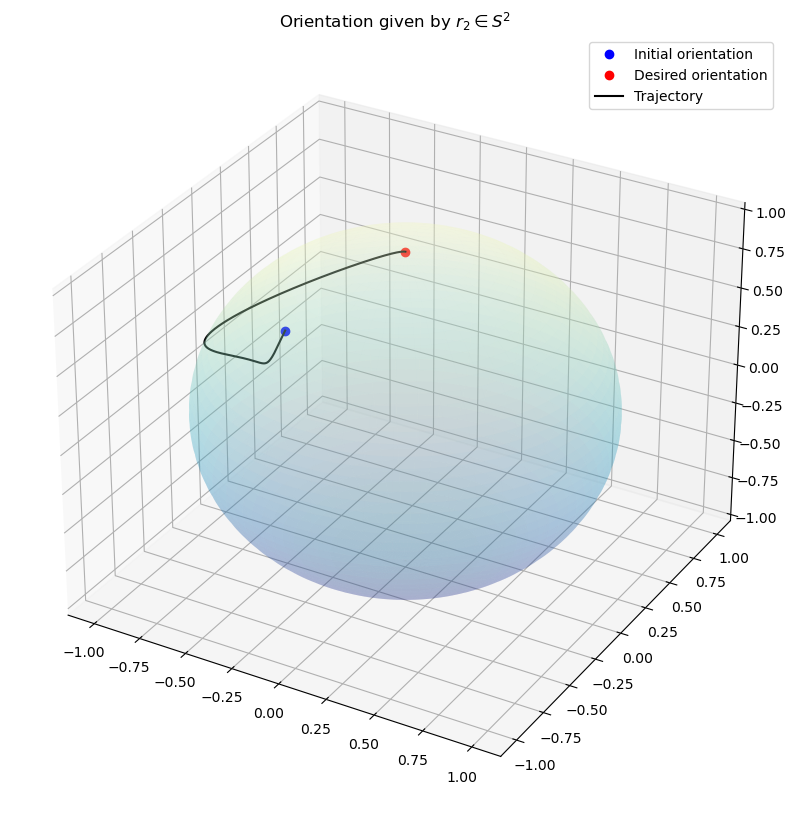

tensor(99.5988, grad_fn=<DivBackward0>)


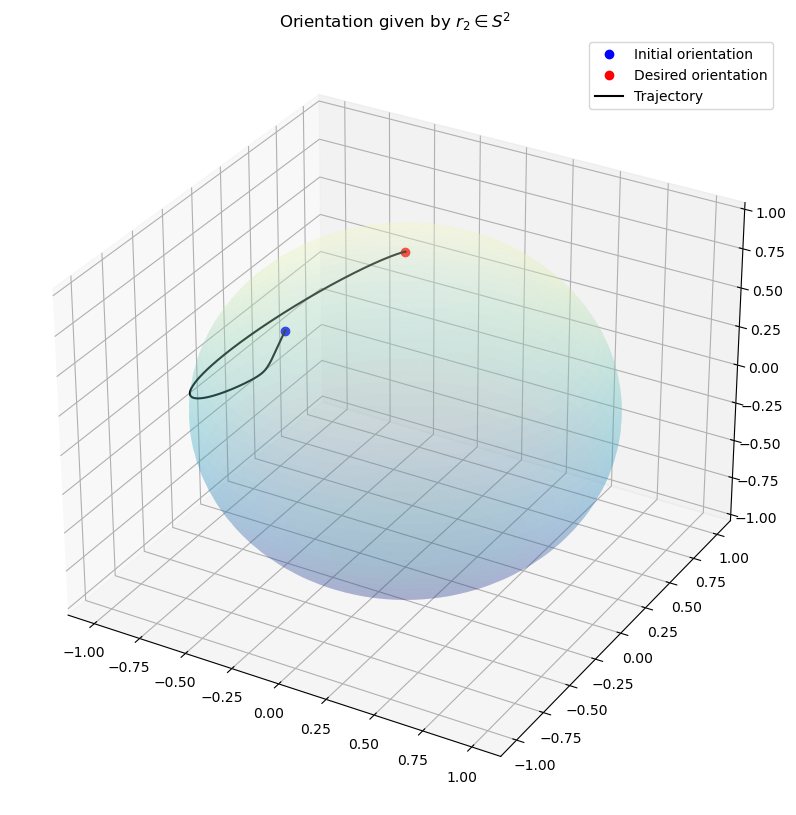

tensor(99.6851, grad_fn=<DivBackward0>)


KeyboardInterrupt: 

In [44]:
R0 = get_orth(3)
Rref = torch.eye(3)
R00 = R0
w0 = torch.tensor([-0.1,0.8,0.3])
diag_I = torch.tensor([1,0.8,1])

Kpd = torch.ones(3,requires_grad=True)
Kdd = torch.ones(3,requires_grad=True)

Kp = torch.diag(Kpd)
Kd = torch.diag(Kdd)

step_size = 0.05

Kds = [Kpd.detach().numpy()]
Kps = [Kdd.detach().numpy()]

for n in range(100):
    Rs = run_control(R0,w0,Rref,diag_I,Kp,Kd,tol=1e-4)

    ax = get_sphere()

    R00p = R00.detach().numpy()
    Rrefp = Rref.detach().numpy()
    Rsp = Rs.detach().numpy()

    i = 2
    ax.plot3D(R00p[0,i],R00p[1,i],R00p[2,i],'o',c="blue",label="Initial orientation")
    ax.plot3D(Rrefp[0,i],Rrefp[1,i],Rrefp[2,i],'o',c="red",label="Desired orientation")
    ax.plot3D(Rsp[:,0,i],Rsp[:,1,i],Rsp[:,2,i],'k-',label="Trajectory")
    plt.legend()
    plt.title(f"Orientation given by $r_{i} \in S^2$")
    plt.show()


    d = dist_trajectory(Rs)/dist_so3(R00,Rref)
    print(d)
    d.backward()

    Kpd = Kpd.detach() - step_size*Kpd.grad
    Kdd = Kdd.detach() - step_size*Kdd.grad

    Kds.append(Kdd.detach().numpy())
    Kps.append(Kpd.detach().numpy())

    Kpd.requires_grad = True
    Kdd.requires_grad = True


    Kp = torch.diag(Kpd)
    Kd = torch.diag(Kdd)





In [ ]:
Rs = [R0]
ws = [w0]

for n in range(N):
    R0 = Rs[-1]
    w0 = ws[-1]

    #Lie Euler
    Rs.append(R0@rodrigues(dt*R_dot(w0)))
    #Explicit Euler
    ws.append(w0 + dt*w_dot_es_di(w0,R0))

Rs = torch.stack(Rs)
ws = torch.stack(ws)


d = dist_trajectory(Rs)/dist_so3(R00,Rref)
d.backward()

Kp.grad

TypeError: <lambda>() missing 2 required positional arguments: 'Kd' and 'Kp'

In [ ]:
Kp.requires_grad = True
a = torch.linalg.norm(Kp@R0**2)
a.backward()
Kp.grad


tensor([[ 1.1547e+00,  4.3564e-16, -5.9902e-16],
        [ 4.3564e-16,  1.1547e+00, -1.3266e-16],
        [-5.9902e-16, -1.3266e-16,  1.1547e+00]])

In [ ]:
plt.semilogy([check_orth(R) for R in Rs],label="Orthogonality error for R")
plt.semilogy([hamiltonian_rot(w) for w in ws],label="Rotational kinetic energy")
plt.semilogy([hamiltonian_ref(R) for R in Rs],label="Control energy $H_{ref}$")
plt.legend()
plt.title("Energy and orthogonality")
plt.show()


plt.plot(ws)
plt.title(r"$\omega$")
plt.show()

ax = get_sphere()

i = 2
ax.plot3D(R00[0,i],R00[1,i],R00[2,i],'o',c="blue",label="Initial orientation")
ax.plot3D(Rref[0,i],Rref[1,i],Rref[2,i],'o',c="red",label="Desired orientation")
ax.plot3D(Rs[:,0,i],Rs[:,1,i],Rs[:,2,i],'k-',label="Trajectory")
plt.legend()
plt.title(f"Orientation given by $r_{i} \in S^2$")
plt.show()


TypeError: eye() received an invalid combination of arguments - got (int, dtype=numpy.dtype[float64]), but expected one of:
 * (int n, *, Tensor out, torch.dtype dtype, torch.layout layout, torch.device device, bool pin_memory, bool requires_grad)
 * (int n, int m, *, Tensor out, torch.dtype dtype, torch.layout layout, torch.device device, bool pin_memory, bool requires_grad)


# Applying extended controller with only orientation 


In [ ]:
R0 = get_orth(3)
R00 = R0
dt = 0.01
N = 10_000
Rref = np.eye(3)

w0 = np.array([-0.1,0.8,0.3])

Kp = np.diag([1]*3)
Kd = Kp*2
Kc = Kp*20

diag_I = np.array([1,0.8,1])
I = np.diag(diag_I)
I_inv = np.diag(1/diag_I)

In [ ]:
Rs = [R0]
Rcs = [np.eye(3)]
ws = [w0]
wpos= [w0] 

u_es = lambda R: -.5*hat_inv(Kp@Rref.T@R - R.T@Rref@Kp.T)

u_pos = lambda R,Rc : -.5*hat_inv(Kc@Rc.T@R - R.T@Rc@Kc.T) + u_es(R)
Rc_dot = lambda R,Rc : -.5*hat(Kd@(hat_inv(Kc@R.T@Rc - Rc.T@R@Kc.T)))


w_dot_pos = lambda w,R,Rc : I_inv@(hat(I@w)@w + u_pos(R,Rc) )
R_dot = lambda w : hat(w) 


for n in range(N):
    R0 = Rs[-1]
    w0 = ws[-1]
    Rc0 = Rcs[-1]

    Rs.append(R0@rodrigues(dt*R_dot(w0)))
    Rcs.append(Rc0@rodrigues(dt*Rc_dot(R0,Rc0)))
    ws.append(w0 + dt*w_dot_pos(w0,R0,Rc0))


Rs = np.stack(Rs)
Rcs = np.stack(Rcs)
ws = np.stack(ws)


hamiltonian_ref = lambda R : .5*np.trace(Kp@(np.eye(3) - Rref.T@R))
hamiltonian_ref_c = lambda Rc,R : .5*np.trace(Kc@(np.eye(3) - Rc.T@R))
hamiltonian_rot = lambda w : 0.5*w.T@I_inv@w


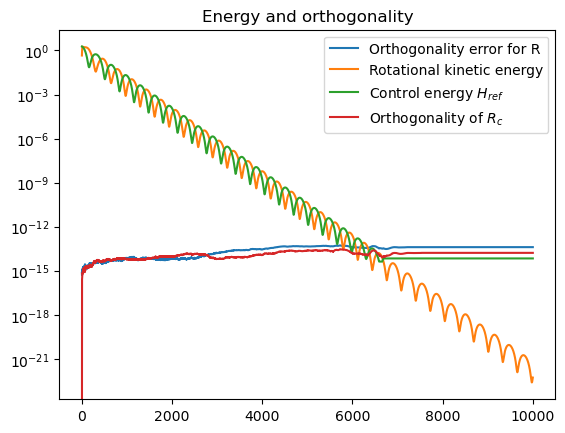

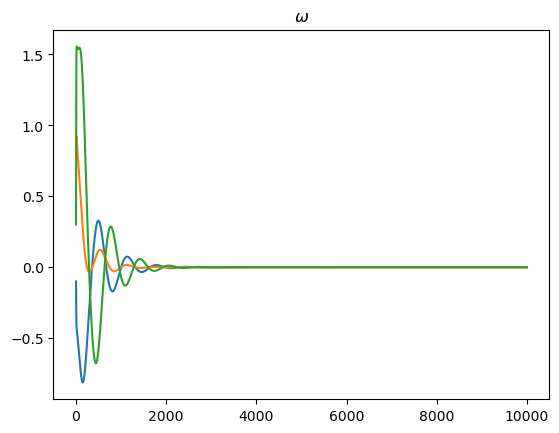

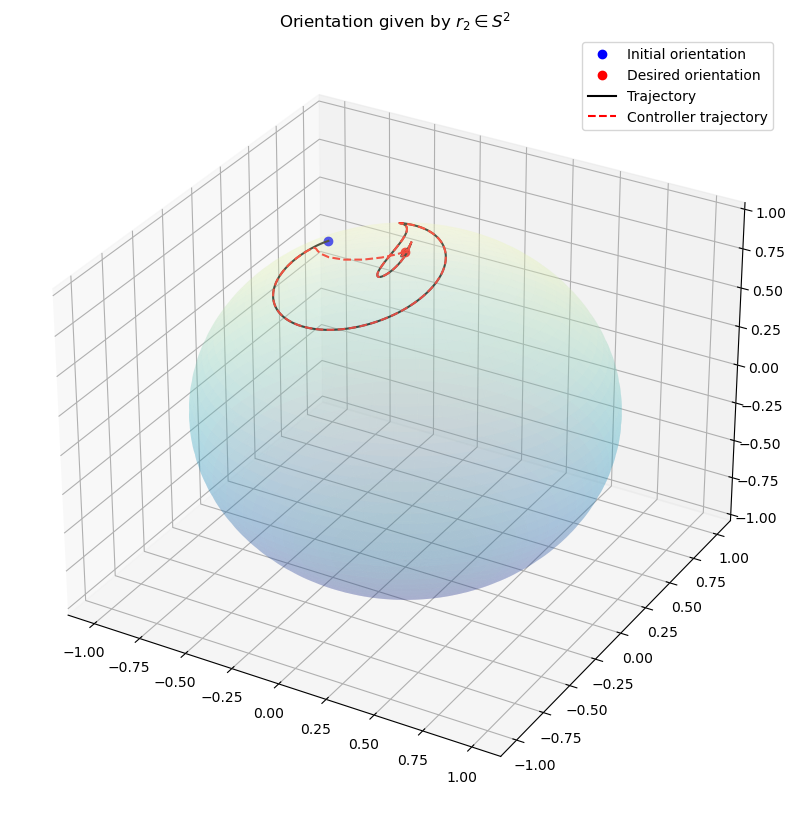

In [ ]:
plt.semilogy([check_orth(R) for R in Rs],label="Orthogonality error for R")
plt.semilogy([hamiltonian_rot(w) for w in ws],label="Rotational kinetic energy")
plt.semilogy([hamiltonian_ref(R) for R in Rs],label="Control energy $H_{ref}$")
plt.semilogy([check_orth(R) for R in Rcs],label = "Orthogonality of $R_c$")
plt.legend()
plt.title("Energy and orthogonality")
plt.show()


plt.plot(ws)
plt.title(r"$\omega$")
plt.show()

ax = get_sphere()

i = 2
ax.plot3D(R00[0,i],R00[1,i],R00[2,i],'o',c="blue",label="Initial orientation")
ax.plot3D(Rref[0,i],Rref[1,i],Rref[2,i],'o',c="red",label="Desired orientation")
ax.plot3D(Rs[:,0,i],Rs[:,1,i],Rs[:,2,i],'k-',label="Trajectory")
ax.plot3D(Rcs[:,0,i],Rcs[:,1,i],Rcs[:,2,i],'r--',label="Controller trajectory")
plt.legend()
plt.title(f"Orientation given by $r_{i} \in S^2$")
plt.show()
